https://iopscience.iop.org/article/10.1088/1555-6611/aaf63d 
H Ahmad et al 2019 Laser Phys. 29 025301

First, construct the geometry of the waveguide and create a mesh. Then generate the effective refractive index and effective mode area of the waveguide using femwell.

start


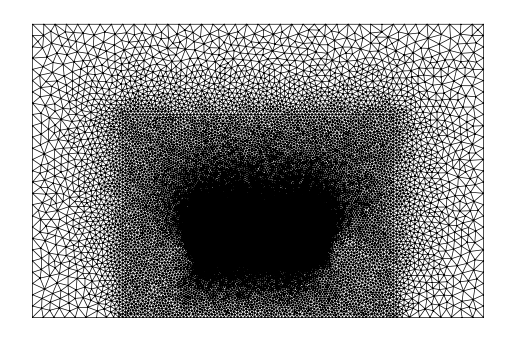

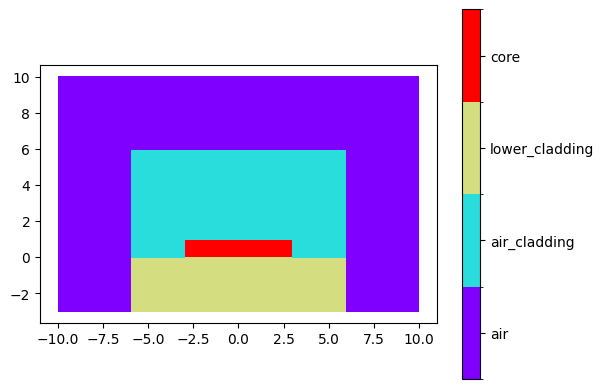

  0%|          | 0/100 [00:00<?, ?it/s]

effective area:2.734185090045947


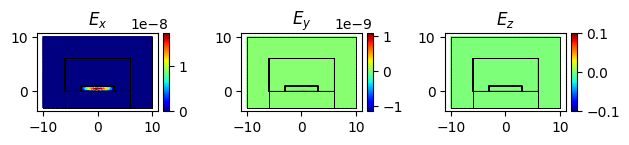

  1%|          | 1/100 [00:44<1:13:36, 44.62s/it]


KeyboardInterrupt: 

In [1]:
import shapely
from generate_neff_and_aeff import get_neff_and_aeff
from refractive_index import n_MgF2, n_Si3N4, n_Air
from collections import OrderedDict
import numpy as np

# waveguide parameters
width = 6  # um
height = 1  # um

n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

wavelength_range = [207, 8000]
wavelegnth_step = 100  # 50nm steps

n_core = n_Si3N4
n_lower_cladding = n_MgF2
n_air = n_Air
#print(n_Si3N4(6))

# Construct waveguide geometry
core = shapely.geometry.box(-width / 2, 0, +width / 2, height)
lower_cladding = shapely.geometry.box(-width, -3, width, 0)
air_cladding = shapely.geometry.box(-width, 0, width, width)
air = shapely.geometry.box(-10, -3, 10, 10)
polygons = OrderedDict(
    core=core,
    lower_cladding=lower_cladding,
    air_cladding=air_cladding,
    air=air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.04, "distance": 0.2},
                   air_cladding={"resolution": 0.15, "distance": 0.5},
                   lower_cladding={"resolution": 0.15, "distance": 0.5},
                   air={"resolution": 0.5, "distance": 1})

n_dict = {"core": n_core, "lower_cladding": n_lower_cladding, "air_cladding": n_air, "air": n_air}

print("start")
# Calculate dispersion and gamma
aeff_list, neff_list, wls = get_neff_and_aeff(polygons, n_dict, wavelength_range, wavelegnth_step, resolutions,
                                              show=True)

##save data
np.savez(f"data_h_{height}_w_{width}", wls=wls, aeff_list=aeff_list, neff_list=neff_list)

print("end")
print(aeff_list)
print(wls)

Reproducing GVD Graph

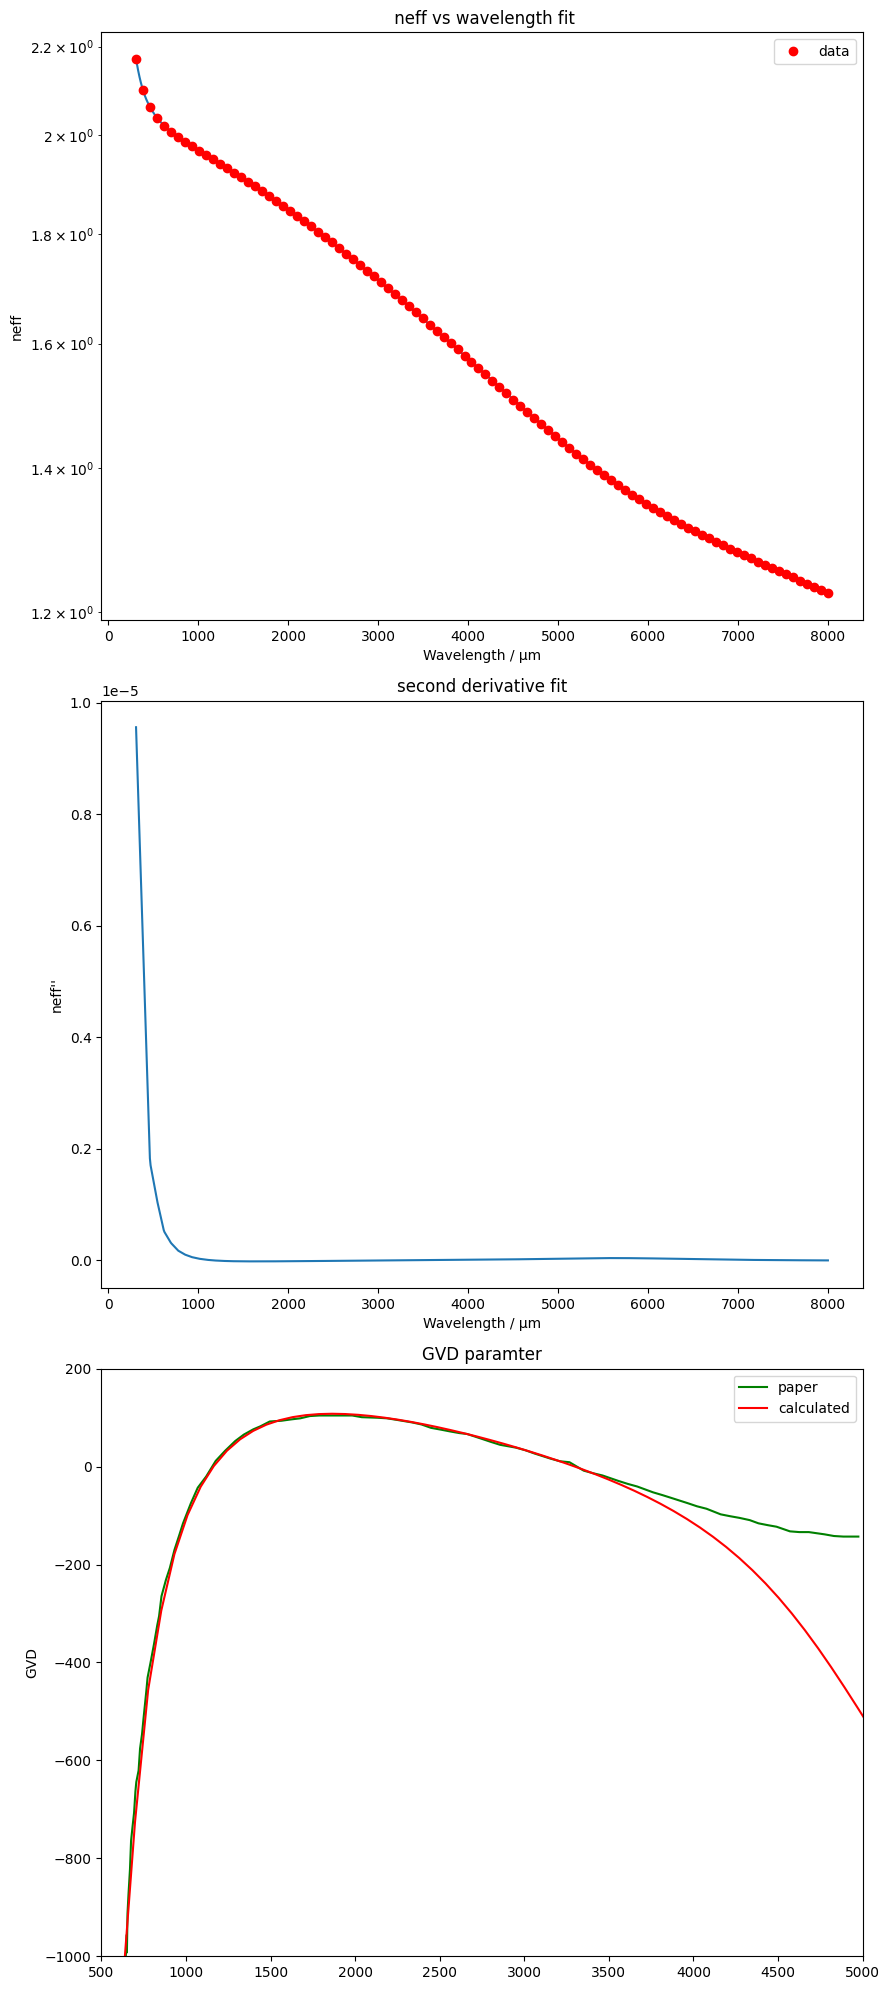

In [1]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
import pandas as pd
from scipy.constants import speed_of_light

width = 6  # um
height = 1  # um

data = np.load(f"data_h_{height}_w_{width}.npz")
neff_list = np.array(data['neff_list'])
wls = data['wls']

fig, axs = plt.subplots(3, 1, figsize=(9, 20))

y_spl = UnivariateSpline(wls, neff_list, s=0, k=3)
x_range = np.linspace(wls[0], wls[-1], 1000)

axs[0].set_xlabel("Wavelength / µm")
axs[0].set_ylabel("neff")
axs[0].set_title(" neff vs wavelength fit")
axs[0].semilogy(x_range, y_spl(x_range))
axs[0].semilogy(wls, neff_list, 'ro', label='data')
axs[0].legend()

y_spl_2d = y_spl.derivative(n=2)
axs[1].set_xlabel("Wavelength / µm")
axs[1].set_ylabel("neff''")
axs[1].set_title("second derivative fit")
axs[1].plot(x_range, y_spl_2d(x_range))

ref_gvd = pd.read_csv("../reference_data/GVD2.csv", dtype=np.float64)
ref_gvd_x, ref_gvd_y = np.split(ref_gvd.values, 2, axis=1)
axs[2].plot(ref_gvd_x, ref_gvd_y, c="green", label="paper")

GVD = (-wls / (2.99792e-7) * y_spl_2d(wls))
axs[2].plot(wls, GVD, label="calculated", c="red")

axs[2].set_ylabel("GVD")
axs[2].set_ylim(-1000, 200)
axs[2].set_xlim(500, 5000)
axs[2].set_title("GVD paramter")
axs[2].legend()

plt.tight_layout()
plt.show()

Use laserfun to reproduce the spectrum of Fig 5d)


[2.17078258 2.09925278 2.06187577 2.0383505  2.02145712 2.00806301
 1.99662493 1.98631285 1.97665107 1.967354   1.95824434 1.94920942
 1.94017668 1.93109928 1.92194724 1.91270191 1.90335234 1.89389295
 1.88432184 1.87463971 1.8648491  1.85495381 1.84495853 1.83486852
 1.82468948 1.81442729 1.80408802 1.79367776 1.78320261 1.77266865
 1.76208186 1.75144816 1.74077338 1.73006324 1.71932337 1.70855933
 1.69777658 1.6869805  1.67617647 1.66536978 1.65456574 1.64376969
 1.63298699 1.62222311 1.61148361 1.60077424 1.59010095 1.57946996
 1.5688878  1.55836135 1.54789794 1.53750539 1.52719201 1.51696672
 1.50683904 1.49681911 1.48691768 1.47714611 1.46751624 1.45804035
 1.44873097 1.43960065 1.43066176 1.42192617 1.41340488 1.40510771
 1.39704292 1.38921691 1.38163389 1.37429572 1.36720179 1.36034906
 1.3537321  1.34734334 1.34117337 1.33521123 1.3294448  1.32386117
 1.31844696 1.31318863 1.30807277 1.30308626 1.29821648 1.29345138
 1.28877961 1.28419053 1.2796742  1.27522144 1.27082375 1.2664

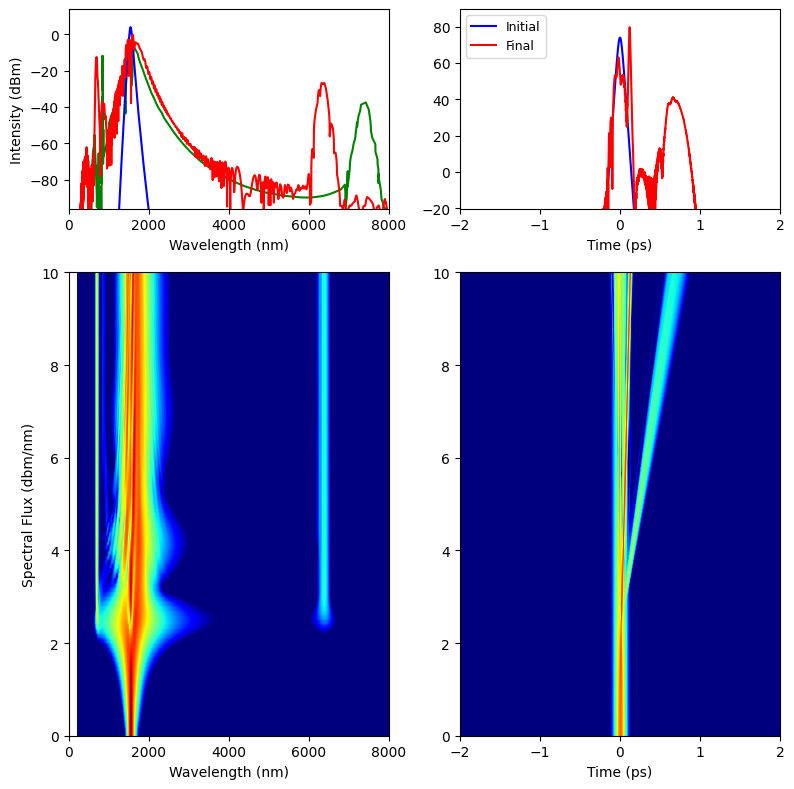

Gamma is 0.27720483468030693/W/m at pump wavelength(1.55um)


In [4]:

import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

# waveguide parameters
width = 6  # um
height = 1  # um

n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

# pulse parameters
FWHM = 50 * 1e-3  # pulse duration (ps)
pulseWL = 1550  # pulse central wavelength (nm)

power = 5000  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion

# simulation parameters
Window = 4  # simulation window (ps)
Steps = 100  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4  # absolute error
Raman = False  # Enable Raman effect?
Steep = True  # Enable self steepening?

# ----------- Build Waveguide -----------
n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

data = np.load(f"data_h_{height}_w_{width}.npz")
wls = data['wls']
neff_list = data['neff_list']
aeff_list = data['aeff_list']
print(neff_list)
print(aeff_list)
print(wls)


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma


# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=False, wav=wls, power=power, RI=neff_list, GDD=GDD, TOD=TOD, FOD=FOD,
             npts=Points)

# create the waveguide
f = lf.Fiber(10 * 1e-3, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(pulseWL), loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
#Plot adjusting
ref_fig5d = pd.read_csv(
    "../reference_data/fig7d.csv", dtype=np.float64
)

fig, axes = results.plot(wavelength=True, show=False, tlim=(-2, 2), flim=(0, 8000), wmax=8000, wmin=200)
ref_fig5d_x, ref_fig5d_y = np.split(ref_fig5d.values, 2, axis=1)

axes[0][0].plot(ref_fig5d_x, ref_fig5d_y, c="green", label="ref spectrum", zorder=0)

axes[1][0].set_xlim(0, 8000)
plt.set_cmap('jet')
plt.show()
print(f"Gamma is {gamma_function(1550)}/W/m at pump wavelength(1.55um)")